# Classification of Breast Cancer Tumors  
Mike Kelly  

## Introduction
[Statistically](https://www.breastcancer.org/symptoms/understand_bc/statistics), breast cancer is the second leading cause of cancer death in women. The two most significant risk factors leading to breast cancer are *sex* and *age*. Other factors include:
 - Family history
 - Genetics
 - Weight
 
This study will classify breast cancer tumor attributes and predict whether a tumor is benign or malignant. 

![Logo](https://www.breastcancer.org/assets/logo-bco-print-64e3a3bd70d403bcddfd7c365c31800f692ef8d6d545548c978b812b69ed1e22.png)

## Setup

In [17]:
# packages
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import pickle

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

## Load Data

In [2]:
columns = ['sample', 'thickness', 'size_unif', 'shape_unif', 'marginal_adhesion', 'epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
bc_raw = pd.read_csv("data/breast-cancer-wisconsin.data", names=columns, na_values=['?'])

## Data Profiling

In [3]:
# report = pp.ProfileReport(bc_raw, title="Breast Cancer Profile Report", progress_bar=False)
# report.to_file("DataProfile.html")

Uncomment and run the two statements above to regenerate the profile report.  
Shift + right-click [here](./DataProfile.html) and choose "Open link in new tab" to view the profile report. Opening the report in a Jupyter tab will disable the interactive features of the report.

### Profile Conclusions
- Remove eight duplicate rows
- Convert bare_nuclei to numeric
- Class is unbalanced
- Shape and Size uniformity are highly correlated

## Data Cleansing

Before performing any data cleansing operations, let's make a copy of bc_raw

In [4]:
bc_clean = bc_raw.copy()

**Missing Values**  
By running the unique() method on bare_nuclei, we find that there are '?' characters in the column. These were picked up as characters and thus the column was cast as type object.   
```
bc_raw['bare_nuclei'].unique()  
array([ 1., 10.,  2.,  4.,  3.,  9.,  7., '?',  5.,  8.,  6.])  
```
By adding the na_values parameter to the load_csv() method above, Pandas will recognize the ?s as NaNs and cast the column as a float64. A rerun of the profile report now shows there are 16 missing values - all in the bare_nuclei column. For this example, we will drop those rows as opposed to imputing the values in some way.

In [5]:
bc_clean.dropna(inplace=True)
print(bc_clean.shape)

(683, 11)


**Duplicates**  
The profile report says there are eight duplicate rows. However, the duplicate criterion incudes the sample ID. Since we will not be using sample as a feaure, we should check for duplicates across only the measurement and class columns.

In [6]:
bc_clean.drop_duplicates(subset=columns[1:], inplace=True)
print(bc_clean.shape)

(449, 11)


## Model Prep / Spot Check

**Feature and class matrices**

In [7]:
bc_clean = bc_clean.reset_index(drop=True)
bc_clean['class'] = bc_clean['class'].replace({2:0, 4:1})
train_X = bc_clean.loc[:, 'thickness':'mitoses']
train_y = bc_clean.loc[:, 'class']

**Test harness**  
This will evaluate several models using 10-fold cross-validation and display the results of the model metrics. This will allow us to decide on a model in which to focus for optimization. We are looking for the model with the combination of high accuracy and low variance (std. dev. of accuracy).

In [8]:
# create model list for evaluation; name, model definition
models = []
models.append(('Logistic Regression', 'LR', LogisticRegression(max_iter=1000)))
models.append(('k-Nearest Neighbor', 'KNN', KNeighborsClassifier()))
models.append(('Random Forest', 'RF', RandomForestClassifier()))
models.append(('Naive Bayes', 'NB', GaussianNB()))
models.append(('Support Vector Machines', 'SVC', SVC()))

# append all models

# metric names: https://scikit-learn.org/stable/modules/model_evaluation.html
metrics = ['accuracy', 'precision', 'f1']
test_harness_results = pd.DataFrame(columns=['Name', 'Accuracy', 'Std. Dev.', 'Precision', 'f1'])
plot_values = []
plot_labels = []
for name, short, model in models:
    cv_results = cross_validate(model, train_X, train_y, cv=10, scoring=metrics)
    test_harness_results = test_harness_results.append({'Name':name, 'Accuracy':cv_results['test_accuracy'].mean(), 'Std. Dev.':cv_results['test_accuracy'].std(), 
                                                        'Precision':cv_results['test_precision'].mean(), 'f1':cv_results['test_f1'].mean()}, ignore_index=True)
    plot_labels.append(short)
    plot_values.append(cv_results['test_accuracy'])
test_harness_results   

,Name,Accuracy,Std. Dev.,Precision,f1
0,Logistic Regression,0.951111,0.035556,0.956737,0.953750
1,k-Nearest Neighbor,0.951010,0.040724,0.952138,0.953443
2,Random Forest,0.957727,0.033599,0.957147,0.960517
3,Naive Bayes,0.946566,0.030115,0.938191,0.950726
4,Support Vector Machines,0.951061,0.032619,0.945176,0.954406


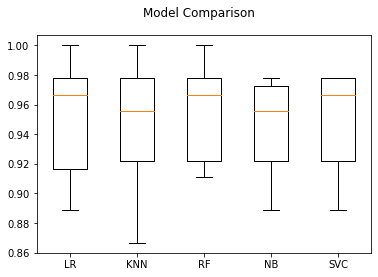

In [9]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(plot_values)
ax.set_xticklabels(plot_labels)
plt.show()

### Model spot-check conclusions  
* All of the models have good accuracy
* Random Forest has the highest accuracy but a fairly large variance
* SVC and NB are very close in accuracy and variance
* SVC has slightly better precision and f1-score than NB. We will optimize a SVC for our production model

## Model Optimization  
Perform a bayesian seach optimization on the SVC hyperparameters  
Optimization will execute 32 runs, each with 5-fold cross-validation to find the best performing hyperparameters for the model

In [13]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, train_size=0.75, test_size=.25, random_state=123)

# optimize hyperparameters
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9464285714285714
test score: 0.9734513274336283


**Conclusion:**  
The model optimization has improved model accuracy by 2%.  
The generalized accuracy on a holdout dataset is now 97.3%.

## Model Metrics  
The plots below show model performance as measured on a holdout dataset.  
**Confusion matrix**

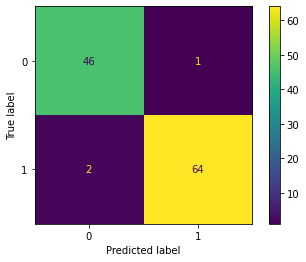

In [16]:
plot_confusion_matrix(opt, X_test, y_test);

**ROC Curve**

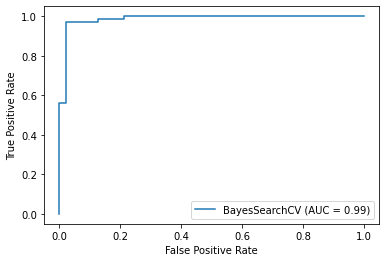

In [18]:
plot_roc_curve(opt, X_test, y_test);

## Model Export  
Export optimized model (opt) as a pickle file. File will be created in current directory and named SVC_BCancer.pkl.

In [ ]:
pickle.dump(opt, open('SVC_BCancer.pkl', 'wb'))